In [410]:
import pandas as pd
import numpy as np
import pymc3 as pm
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import arviz as az

In [411]:
# Generate some fake survival data & add noise
np.random.seed(120)
points=100
#  x values
ex=np.random.random_sample(points)*8
#  alpha
a=stats.beta(2.76,3).rvs(size=points)
#  beta.
b=stats.beta(0.14,7).rvs(size=points)
# noise
epsilon=stats.norm(loc=0,scale=0.2).rvs(size=points)
ey=np.exp(-((0.2)*ex+(0.2)*ex**2)+epsilon*ex)
# preventing y>1
for i in range(0,len(ey)):
    if ey[i]>1:
        ey[i]=ey[i]-np.abs(1-ey[i])
# errors for curve fit
x_err=5*ex/100
y_err=50*ey/100

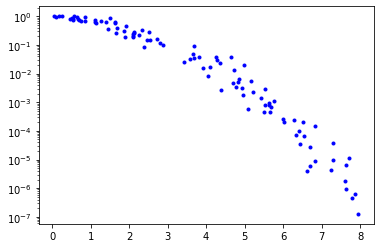

In [412]:
plt.yscale('log')
plt.plot(ex,ey, 'b.')

a:  0.20344396148215688 std:  0.06732344579938697 
 b:  0.231791642894863 std:  0.011746563861599118


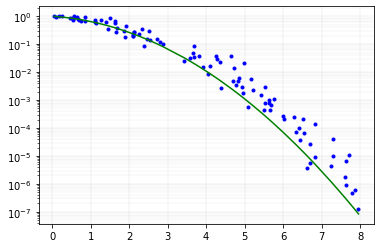

In [413]:
# non linear regression via scipy

def SFmodel(dose,alpha,beta,):
    expterm=(-1)*((alpha*dose)+(beta*dose**2))
    SF = np.exp(expterm)
    return SF

g=[0.4,0.4]

ng,cov=optimize.curve_fit(SFmodel,ex,ey,g,sigma=y_err, bounds=(0,np.inf),method="trf")
n=len(ex)
y=np.empty(n)

for i in range(0,n):
    y[i]=SFmodel(ex[i],ng[0],ng[1])
stdevs=np.sqrt(np.diag(cov))
plt.yscale('log')
plt.plot(ex, ey, 'b.')
plt.grid(b=True, which='major', color='grey', linestyle='-', linewidth='0.1')
plt.grid(b=True, which='minor', color='grey', linestyle='--', linewidth='0.1')
plt.plot(sorted(ex, reverse=True),sorted(y), 'g-')

print('a: ',ng[0],'std: ', stdevs[0], '\n', 'b: ', ng[1], 'std: ', stdevs[1] )

In [402]:
with pm.Model() as survival_model:
    #  Hyperparameters.
    scale_alpha = pm.HalfCauchy('scale_alpha', beta=2.0)
    scale_beta = pm.HalfCauchy('scale_beta', beta=2.0)
    #  Priors on the alpha, beta in LQ model.
    alpha = pm.HalfNormal('alpha', sd=scale_alpha, testval=0.5)
    beta = pm.HalfNormal('beta', sd=scale_beta, testval=0.5)
    epsilon=pm.HalfCauchy("epsilon", beta=1.0)
    #  likelihood.
    y_est=pm.Normal("y_est", mu=np.exp(-(alpha*ex+beta*ex**2)), sd=epsilon, observed=ey)
    #  MCMC.
    step=pm.Metropolis()
    trace=pm.sample(draws=25000,step=step,tune=2000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [scale_beta]
>Metropolis: [scale_alpha]


Sampling 4 chains for 2_000 tune and 25_000 draw iterations (8_000 + 100_000 draws total) took 222 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [403]:
inference_data = az.from_pymc3(trace)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FA217DDF0>,
      dtype=object)

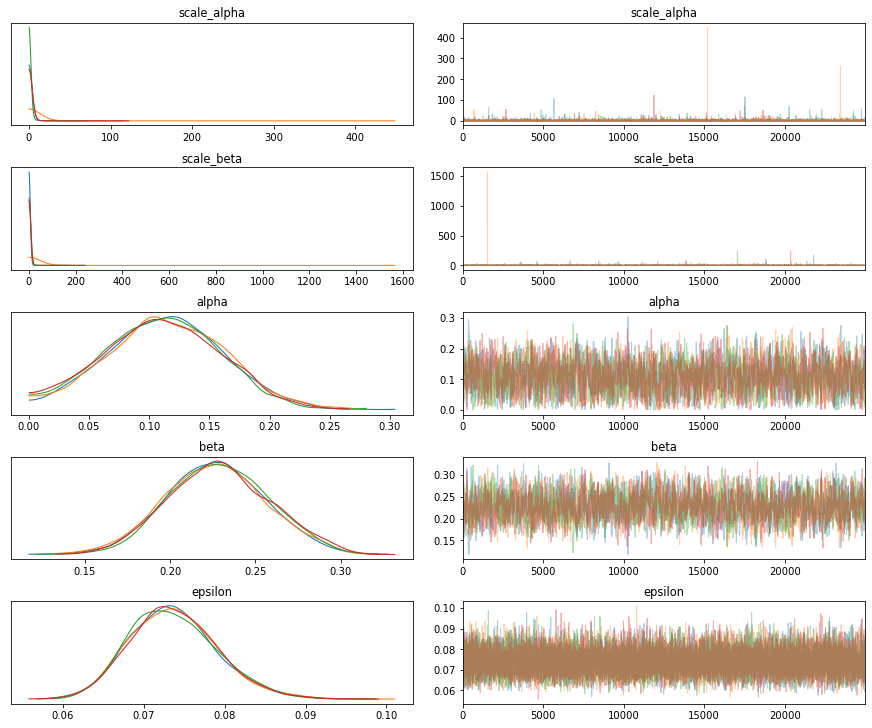

In [404]:
az.plot_trace(inference_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FA13144F0>,
      dtype=object)

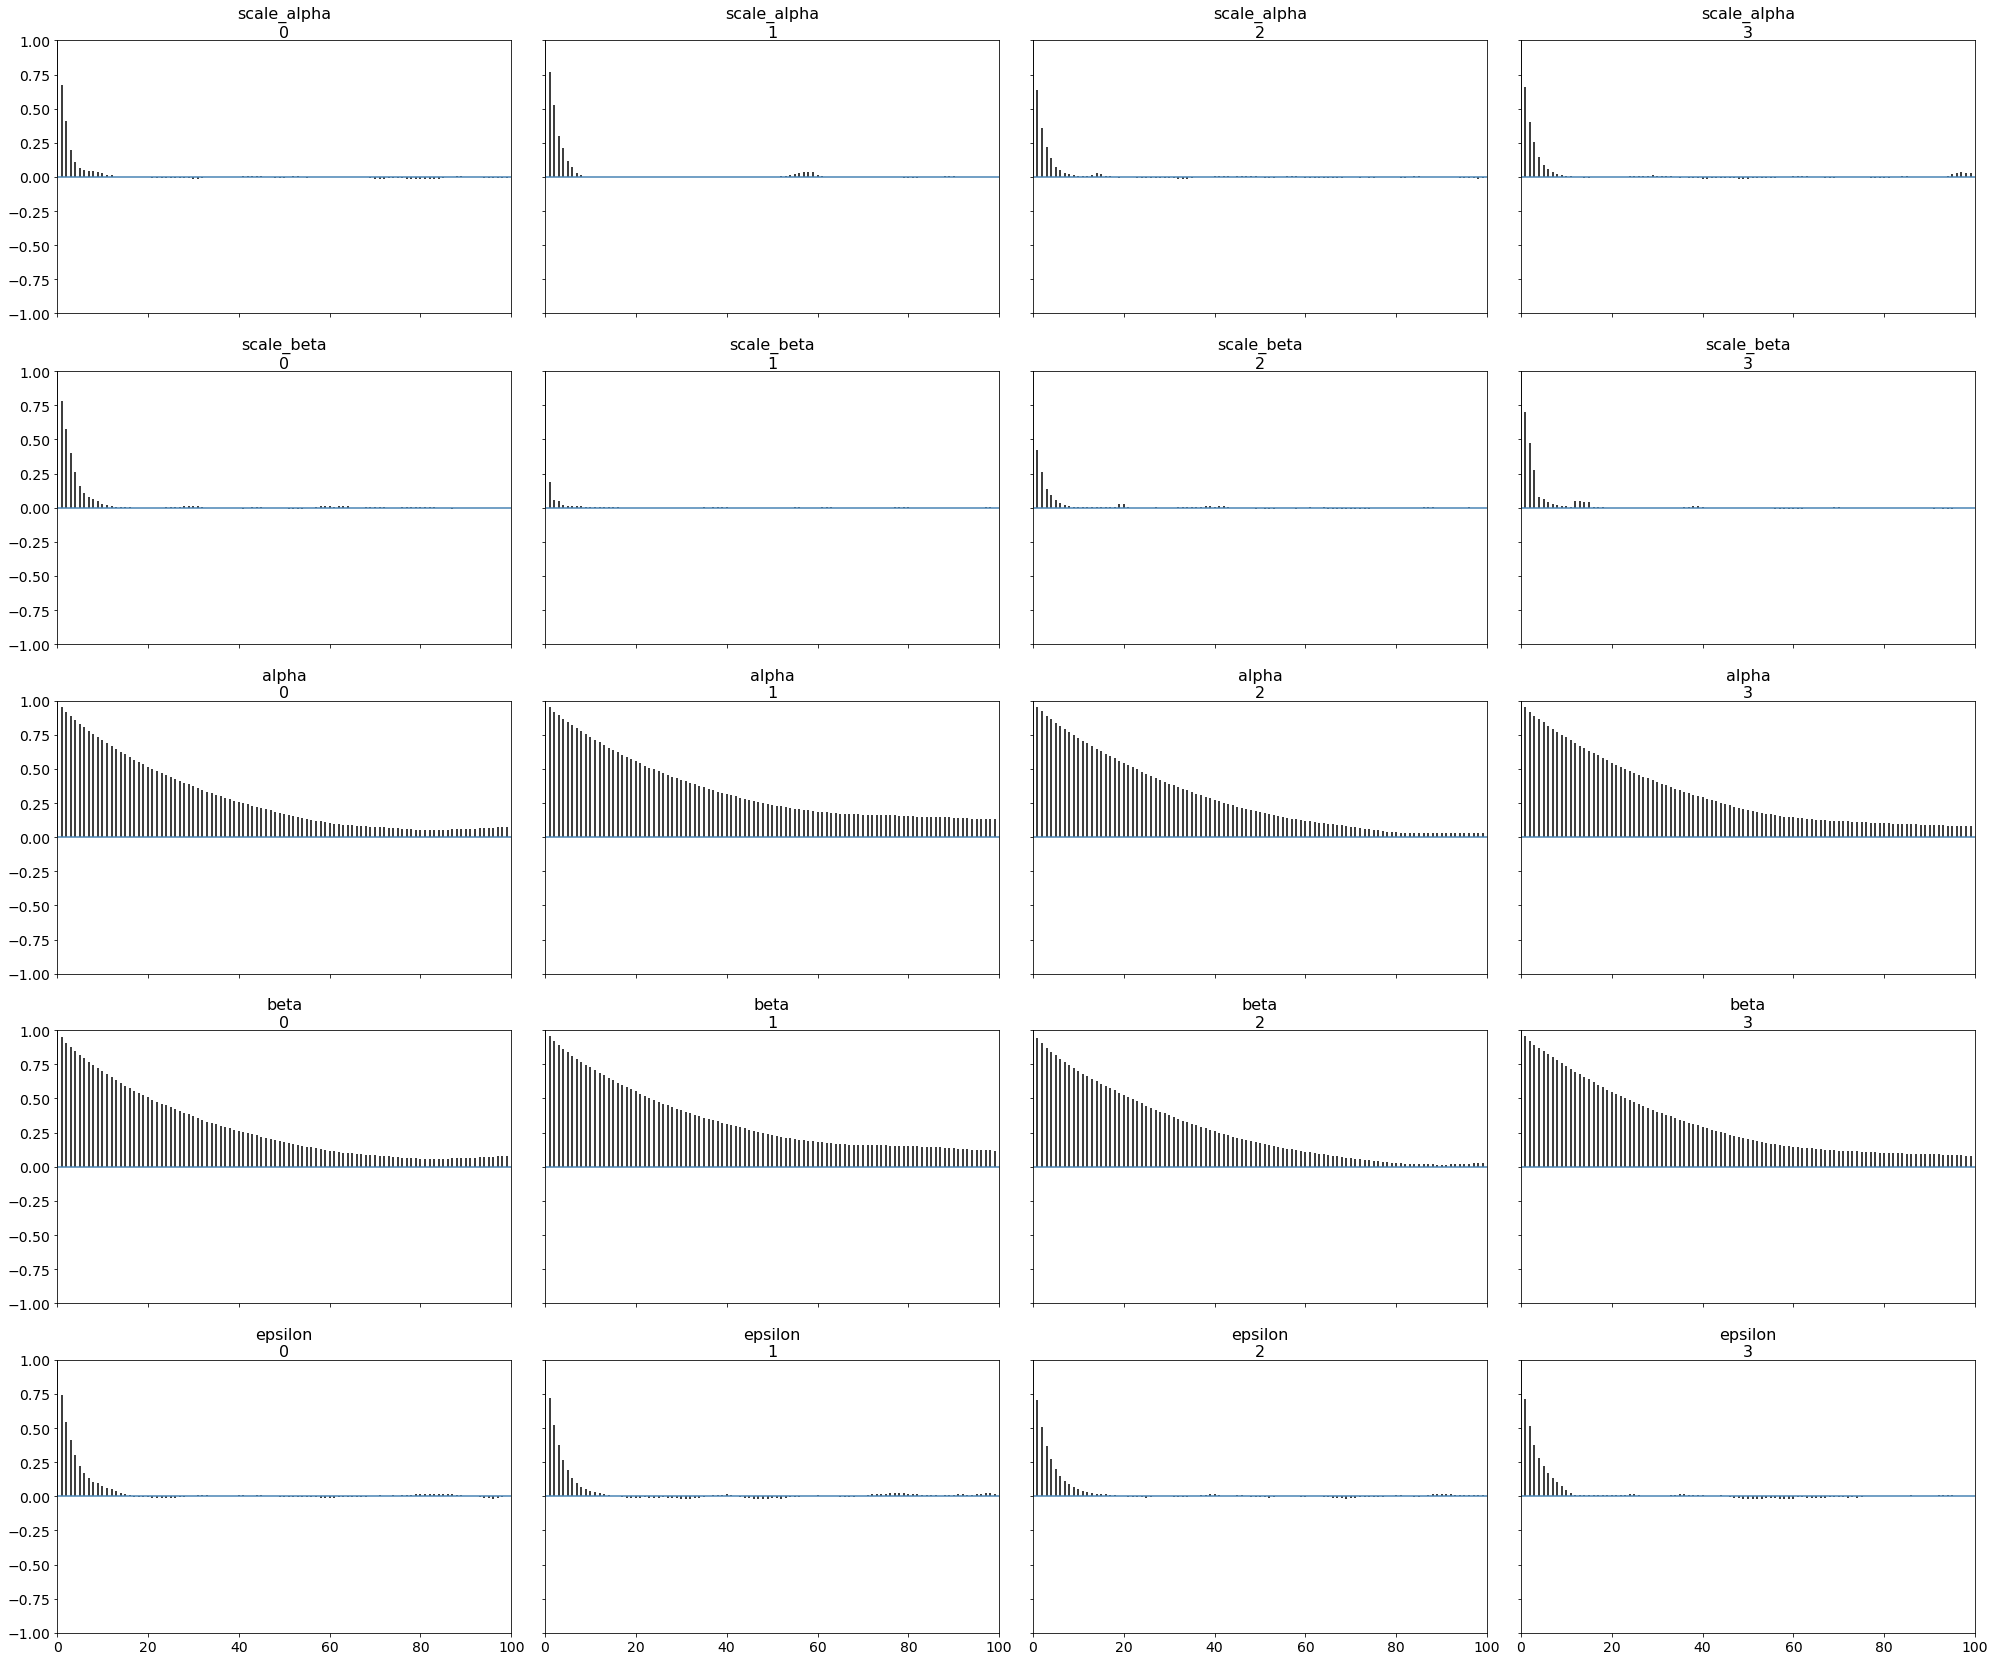

In [405]:
az.plot_autocorr(inference_data)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FA4DE16A0>],
      dtype=object)

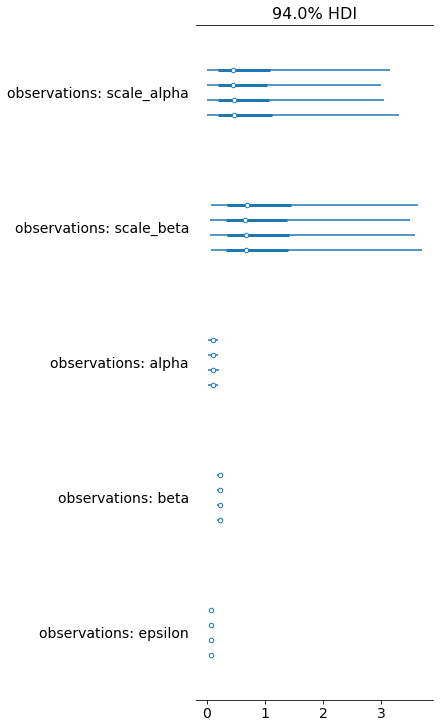

In [406]:
az.plot_forest([trace], model_names=["observations"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FA5B00AC0>,
      dtype=object)

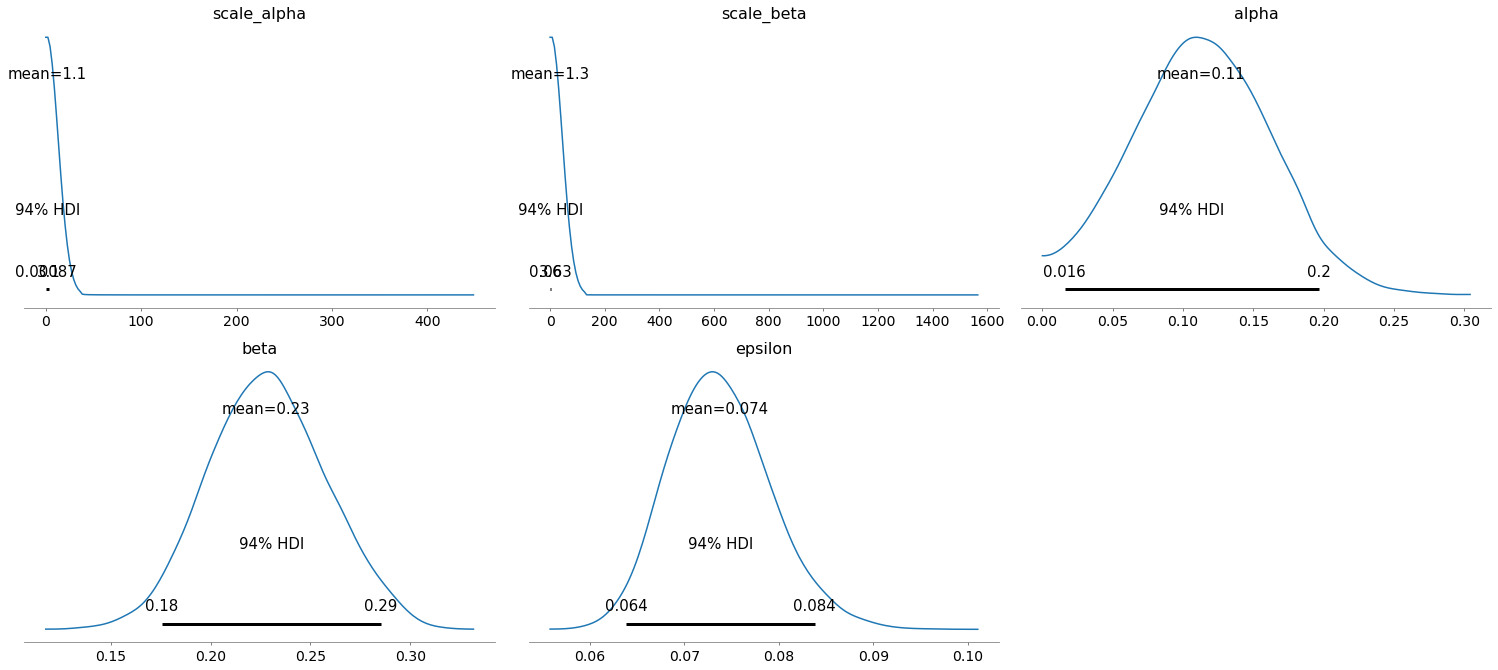

In [407]:
az.plot_posterior(trace)

In [408]:
az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
scale_alpha,1.055,3.861,0.001,3.135,0.027,0.019,20608.0,20608.0,13250.0,11418.0,1.0
scale_beta,1.302,5.841,0.063,3.612,0.030,0.021,38970.0,38970.0,19299.0,22326.0,1.0
alpha,0.113,0.048,0.016,0.197,0.001,0.001,1326.0,1326.0,1326.0,2830.0,1.0
beta,0.228,0.029,0.176,0.285,0.001,0.001,1351.0,1351.0,1354.0,3105.0,1.0
epsilon,0.074,0.005,0.064,0.084,0.000,0.000,15426.0,15413.0,15491.0,16968.0,1.0


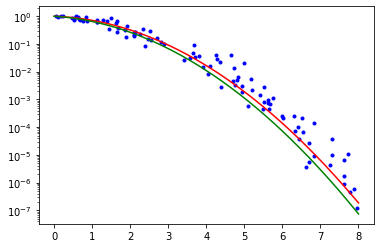

In [409]:
# Taking the output alpha and beta values to plot against the fake observed data.

w=np.linspace(0,8,1000)
def function(thing):
    v=np.exp((-1)*((0.113*w)+(0.228*w**2)))
    return v
v=function(w)
plt.plot(ex,ey, 'b.')
plt.plot(w,v, color='r')

# plotting the scipy curvefit

newx=np.linspace(0,8,500)
newy=np.exp(-(0.203*newx+0.231*newx**2))
plt.yscale('log')
plt.plot(newx,newy, 'g-')
plt.show()